In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import torch
if torch.cuda.is_available():
    import torch.cuda as t
else:
    import torch as t
from torch import nn, optim
from torch.autograd import Variable
from IPython.display import Audio

# new imports - maa2282
from scipy.io import wavfile
import sklearn.preprocessing
from datetime import datetime

In [2]:
class One_Hot(nn.Module):
    def __init__(self, depth):
        super(One_Hot,self).__init__()
        self.depth = depth
        self.ones = t.sparse.torch.eye(depth)
    def forward(self, X_in):
        return Variable(self.ones.index_select(0,X_in.data))
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.depth)

## Wavenet  class
Two generation functions are included. generate_slow( ) is easy to understand, but generate( ) is much faster.

In [3]:
class WaveNet(nn.Module):
    def __init__(self, mu=256,n_residue=32, n_skip= 512, dilation_depth=10, n_repeat=5):
        # mu: audio quantization size
        # n_residue: residue channels
        # n_skip: skip channels
        # dilation_depth & n_repeat: dilation layer setup
        super(WaveNet, self).__init__()
        self.dilation_depth = dilation_depth
        dilations = self.dilations = [2 ** i for i in range(dilation_depth)] * n_repeat
        self.one_hot = One_Hot(mu)
        self.from_input = nn.Conv1d(in_channels=mu, out_channels=n_residue, kernel_size=1)
        self.conv_sigmoid = nn.ModuleList([nn.Conv1d(in_channels=n_residue,
                                                     out_channels=n_residue,
                                                     kernel_size=2,
                                                     dilation=d)
                                           for d in dilations])
        self.conv_tanh = nn.ModuleList([nn.Conv1d(in_channels=n_residue,
                                                  out_channels=n_residue,
                                                  kernel_size=2,
                                                  dilation=d)
                                        for d in dilations])
        self.skip_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue,
                                                   out_channels=n_skip,
                                                   kernel_size=1)
                                         for d in dilations])
        self.residue_scale = nn.ModuleList([nn.Conv1d(in_channels=n_residue,
                                                      out_channels=n_residue,
                                                      kernel_size=1)
                                            for d in dilations])
        self.conv_post_1 = nn.Conv1d(in_channels=n_skip, out_channels=n_skip, kernel_size=1)
        self.conv_post_2 = nn.Conv1d(in_channels=n_skip, out_channels=mu, kernel_size=1)
        
    def forward(self, input):
        output = self.preprocess(input)
        skip_connections = [] # save for generation purposes
        for s, t, skip_scale, residue_scale in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale):
            output, skip = self.residue_forward(output, s, t, skip_scale, residue_scale)
            skip_connections.append(skip)
        # sum up skip connections
        output = sum([s[:,:,-output.size(2):] for s in skip_connections])
        output = self.postprocess(output)
        return output
    
    def preprocess(self, input, cuda=True):
        output = self.one_hot(input).unsqueeze(0).transpose(1,2)
        if cuda:
            output = self.from_input(output.cuda())
        else:
            output = self.from_input(output)
        return output
    
    def postprocess(self, input):
        output = nn.functional.elu(input)
        output = self.conv_post_1(output)
        output = nn.functional.elu(output)
        output = self.conv_post_2(output).squeeze(0).transpose(0,1)
        return output
    
    def residue_forward(self, input, conv_sigmoid, conv_tanh, skip_scale, residue_scale):
        output = input
        output_sigmoid, output_tanh = conv_sigmoid(output), conv_tanh(output)
        output = nn.functional.sigmoid(output_sigmoid) * nn.functional.tanh(output_tanh)
        skip = skip_scale(output)
        output = residue_scale(output)
        output = output + input[:,:,-output.size(2):]
        return output, skip
    
    def generate_slow(self, input, n=100):
        res = input.data.tolist()
        for _ in range(n):
            x = Variable(t.LongTensor(res[-sum(self.dilations)-1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            res.append(i.data.tolist()[-1])
        return res
    
    def generate(self, input=None, n=100, temperature=None, estimate_time=False, use_cuda=False):
        ## prepare output_buffer
        output = self.preprocess(input, cuda=use_cuda)
        output_buffer = []
        for s, t_, skip_scale, residue_scale, d in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, self.dilations):
            output, _ = self.residue_forward(output, s, t_, skip_scale, residue_scale)
            sz = 1 if d==2**(self.dilation_depth-1) else d*2
            output_buffer.append(output[:,:,-sz-1:-1])
        ## generate new 
        res = input.data.tolist()
        for i in range(n):
            output = Variable(torch.LongTensor(res[-2:]))
            output = self.preprocess(output, cuda=use_cuda)
            output_buffer_next = []
            skip_connections = [] # save for generation purposes
            for s, t, skip_scale, residue_scale, b in zip(self.conv_sigmoid, self.conv_tanh, self.skip_scale, self.residue_scale, output_buffer):
                output, residue = self.residue_forward(output, s, t, skip_scale, residue_scale)
                output = torch.cat([b, output], dim=2)
                skip_connections.append(residue)
                if i%100==0:
                    output = output.clone()
                output_buffer_next.append(output[:,:,-b.size(2):])
            output_buffer = output_buffer_next
            output = output[:,:,-1:]
            # sum up skip connections
            output = sum(skip_connections)
            output = self.postprocess(output)
            if temperature is None:
                _, output = output.max(dim=1)
            else:
                output = output.div(temperature).exp().multinomial(1).squeeze()
            res.append(output.data[-1])
        return res

## test network forward( )

In [4]:
net = WaveNet(mu=128)
net.cuda()
batch = Variable(torch.from_numpy(np.random.randint(0,128,10000).astype(np.long)))
net(batch)

Variable containing:
 3.6114e-02 -1.1463e-01 -9.2847e-02  ...   2.2228e-01 -3.9178e-01 -1.3501e-01
 4.7588e-02 -1.8096e-01 -1.0204e-01  ...   2.2484e-01 -3.7922e-01 -1.5597e-01
 5.9198e-02 -1.7302e-01 -9.9105e-02  ...   2.6624e-01 -4.1108e-01 -1.4927e-01
                ...                   ⋱                   ...                
 4.6773e-02 -1.8788e-01 -1.1615e-01  ...   2.3218e-01 -3.7850e-01 -1.4511e-01
 4.2990e-02 -1.3785e-01 -8.0325e-02  ...   2.1995e-01 -3.7578e-01 -1.7354e-01
 5.0974e-02 -1.7323e-01 -1.1784e-01  ...   2.5149e-01 -3.8415e-01 -1.8927e-01
[torch.cuda.FloatTensor of size 4885x128 (GPU 0)]

## test generation

- generate_slow( ) is easy to understand
- generate( ) is faster than generate_slow( )

In [5]:
net = net.cpu()
%time y_gen = net.generate(batch, 20)
net = net.cuda()
#%time y_gen2 = net.generate_slow(batch, 20)

CPU times: user 1.81 s, sys: 222 ms, total: 2.04 s
Wall time: 1.55 s


In [6]:
y_gen[-5:]

[41, 74, 74, 74, 74]

## $\mu$-law encode and decode

In [7]:
def encode_mu_law(x, mu=256):
    mu = mu - 1
    fx = np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)
    return np.floor((fx + 1) / 2 * mu + 0.5).astype(np.long)

def decode_mu_law(y, mu=256):
    mu = mu-1
    fx = (y-0.5)/mu*2-1
    x = np.sign(fx)/mu*((1+mu)**np.abs(fx)-1)
    return x  

## Noise Sine Wave

In [ ]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0, 5, framerate * 5)
    data = np.sin(2 * np.pi * 220 * t) + np.sin(2 * np.pi * 224 * t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start: start + seq_size]
        ys = encode_mu_law(ys, mu)
        yield Variable(torch.from_numpy(ys[: seq_size]))
        
g = sine_generator(mu=64, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(x.data.tolist(),'.', ms=1)

## sine wave generator

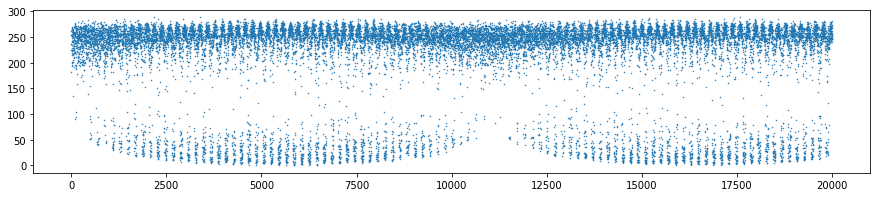

In [37]:
def sine_generator(seq_size = 6000, mu=256):
    framerate = 44100
    t = np.linspace(0, 5, framerate * 5)
    data = np.sin(2 * np.pi * 220 * t) + np.sin(2 * np.pi * 224 * t)
    data = data/2
    while True:
        start = np.random.randint(0,data.shape[0]-seq_size)
        ys = data[start: start + seq_size]
        ys += abs(np.random.normal(0,1,len(ys)))
        ys = encode_mu_law(ys, mu)
        yield Variable(torch.from_numpy(ys[: seq_size]))
        
g = sine_generator(mu=256, seq_size=20000)
x = next(g)
plt.figure(figsize=[15,3])
plt.plot(x.data.tolist(),'.', ms=1)

## listen to the signal

In [9]:
y = x.data.numpy()
y = decode_mu_law(y, 64)
Audio(y, rate=44100)

## network training

This network tries to generate the vibrating sine wave above. 
- The audio signal is quantized to 64 discrete integers.
- 24 channels in residue outputs
- 128 channels in skip outputs
- 20 dilation layers (n_repeat=2, dilation_depth=10)

In [10]:
freq = None
def get_wavfile(fname):
    global freq
    freq, data = wavfile.read(fname)
    # normalize our audio file. otherwise we have some divide-by-zero errors
    norm = sklearn.preprocessing.normalize(data.reshape(-1, 1), axis=0).reshape(-1)
    return norm

def encode_wav(fname, mu):
    return encode_mu_law(get_wavfile(fname), mu)

def get_file_sample(fname, seq_size):
    mu_law_encoded_sample = encode_wave(fname)
    rand_start = np.random.choice(len(mu_law_encoded_sample) - seq_size)
    sample = mu_law_encoded_sample[rand_start: rand_start + seq_size]
    return sample

def file_sample_generator(fname, seq_size, mu):
    data = encode_wav(fname, mu)
    while True:
        rand_start = np.random.choice(len(data) - seq_size)
        sample = data[rand_start: rand_start + seq_size]
        yield Variable(torch.from_numpy(sample))

wavfile_name = "data/piano_new.wav"
sample_gen = file_sample_generator(wavfile_name, 2200, 256)
freq, data = wavfile.read(wavfile_name)
print(len(data))
Audio(data[20000:28000], rate=16000)

170237


2018-04-20 20:14:39.515227 epoch 0, loss 2.9397077560424805


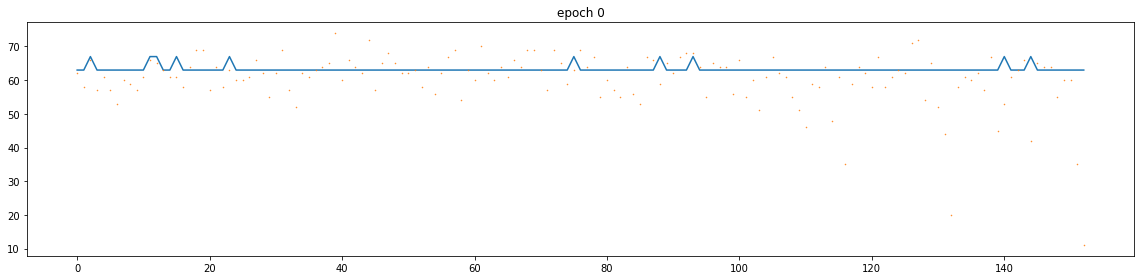

2018-04-20 20:16:56.175494 epoch 100, loss 0.8305591940879822


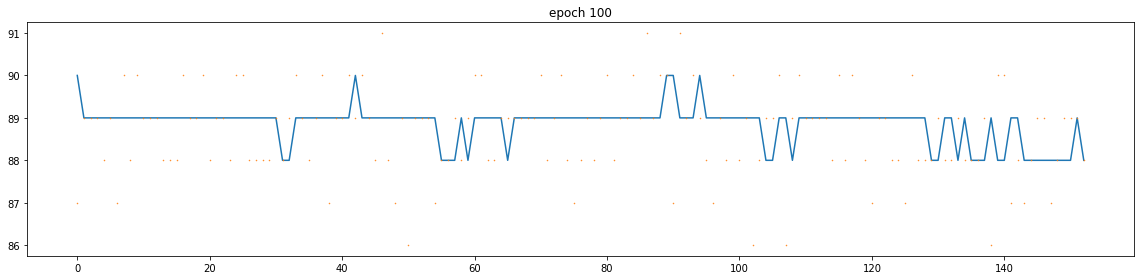

2018-04-20 20:19:13.886996 epoch 200, loss 0.673478364944458


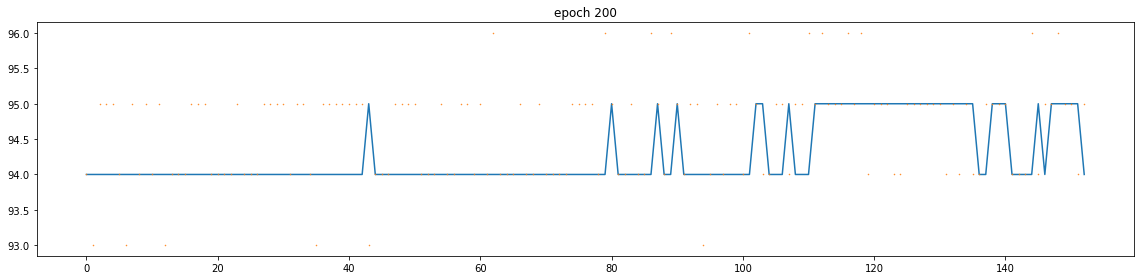

2018-04-20 20:21:30.723729 epoch 300, loss 0.5535389184951782


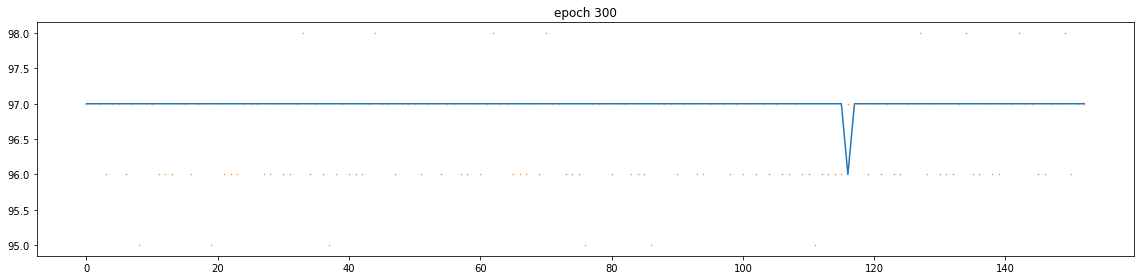

2018-04-20 20:23:48.230426 epoch 400, loss 0.4658685624599457


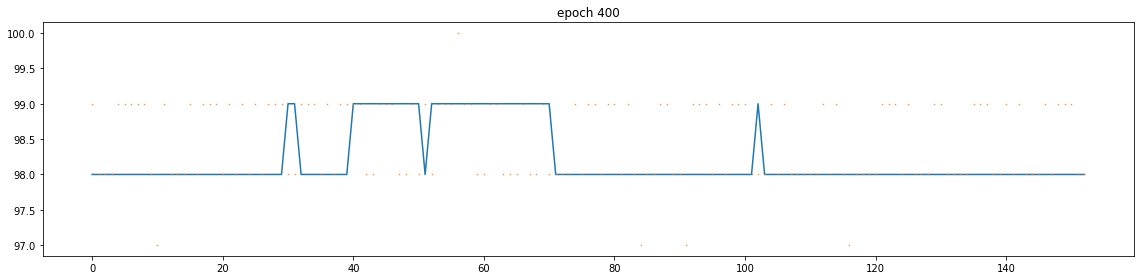

2018-04-20 20:26:05.430028 epoch 500, loss 0.4297984838485718


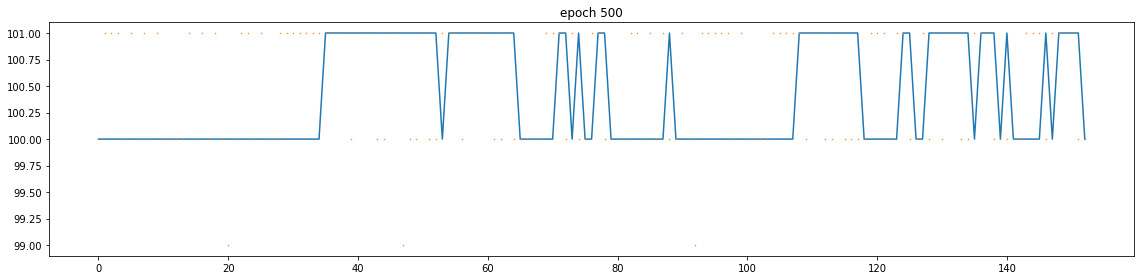

2018-04-20 20:28:23.528893 epoch 600, loss 0.41133585572242737


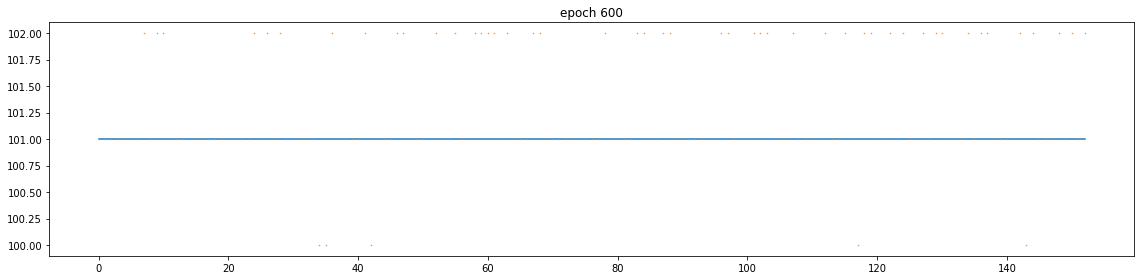

2018-04-20 20:30:40.976033 epoch 700, loss 0.5234012603759766


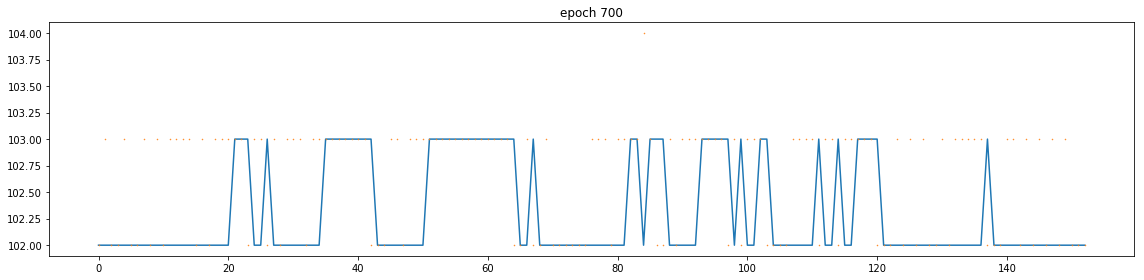

2018-04-20 20:32:58.330859 epoch 800, loss 0.38113752007484436


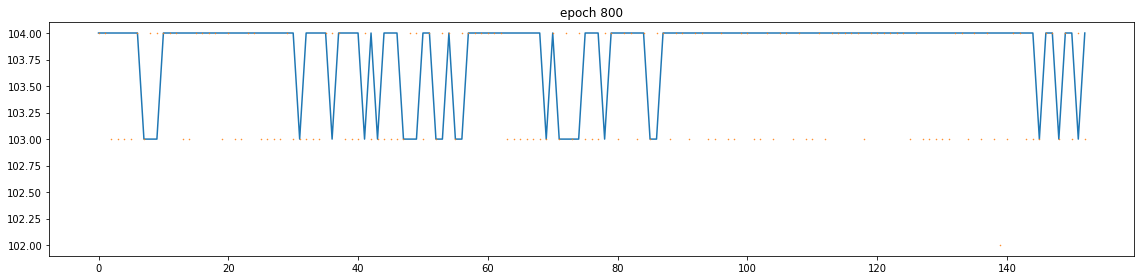

2018-04-20 20:35:15.865775 epoch 900, loss 0.3685372769832611


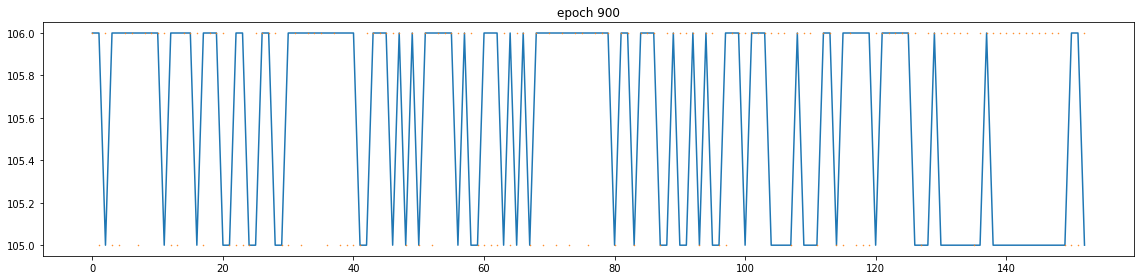

In [29]:
net = WaveNet(mu=256,n_residue=24,n_skip=128,dilation_depth=10,n_repeat=2)
net.cuda()
optimizer = optim.Adam(net.parameters(),lr=0.01)
g = sine_generator(seq_size=2200,mu=64)
#g = file_sample_generator(fname=wavfile_name, seq_size=6400, mu=256)
batch_size = 64
#batch = next(g)

loss_save = []
max_epoch = 1000
for epoch in range(max_epoch):
    optimizer.zero_grad()
    loss = 0
    for _ in range(int(len(batch)/batch_size)):
        batch = next(g)
        x = batch[:-5]
        logits = net(x)
        sz = logits.size(0)
        loss += nn.functional.cross_entropy(logits, batch[-sz:].cuda())
    loss = loss / batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    # monitor progress
    if epoch%100==0:
        print('{} epoch {}, loss {}'.format(str(datetime.now()), epoch, loss.data[0]))
        #batch = next(g)
        logits = net(batch[:-1])
        _, i = logits.max(dim=1)
        plt.figure(figsize=[16, 4])
        plt.plot(i.data.tolist())
        plt.plot(batch.data.tolist()[sum(net.dilations) + 1:], '.', ms=1)
        plt.title('epoch {}'.format(epoch))
        plt.tight_layout()
        plt.show()

## loss function

Text(0.5,1,'loss function')

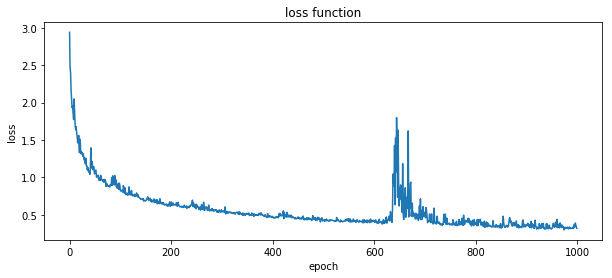

In [30]:
plt.figure(figsize=[10,4])
plt.plot(loss_save)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss function')

## data generation

In [34]:
%time y_gen = net.generate(x, 4000, use_cuda=True)

CPU times: user 47.5 s, sys: 200 ms, total: 47.7 s
Wall time: 47.7 s


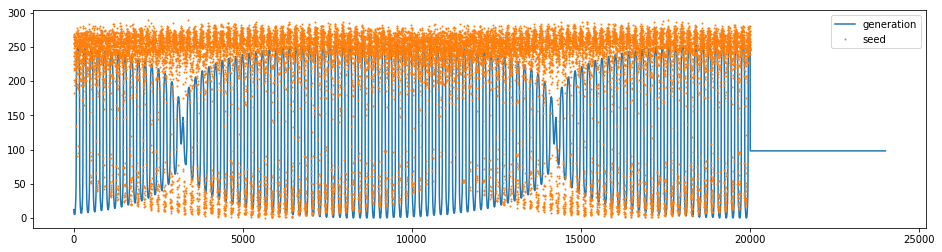

In [38]:
plt.figure(figsize=[16,4])
plt.plot(y_gen)
plt.plot(x.data.tolist(),'.',ms=2)
plt.legend(['generation','seed'])

In [36]:
Audio(y_gen, rate=8000)

In [33]:
%time y_gen = net.generate_slow(batch[:3200], 4000)

TypeError: index_select received an invalid combination of arguments - got ([32;1mint[0m, [31;1mtorch.cuda.LongTensor[0m), but expected (int dim, torch.LongTensor index)

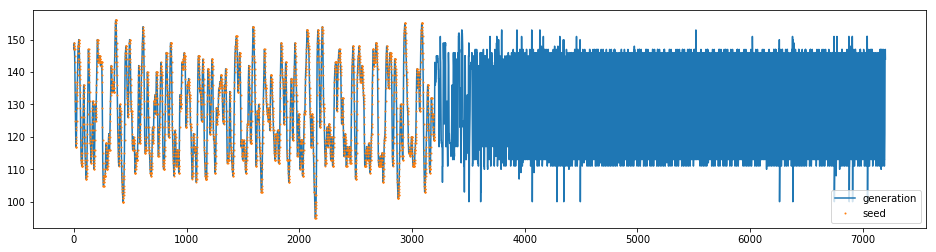

In [25]:
plt.figure(figsize=[16,4])
plt.plot(y_gen)
plt.plot(batch.data[:3200].tolist(),'.',ms=2)
plt.legend(['generation','seed'])

In [37]:
y_new = np.array(y_gen)
y_new = y_new-y_new.mean()

In [56]:
len(batch)

6400

In [55]:
len(y_new)

7200

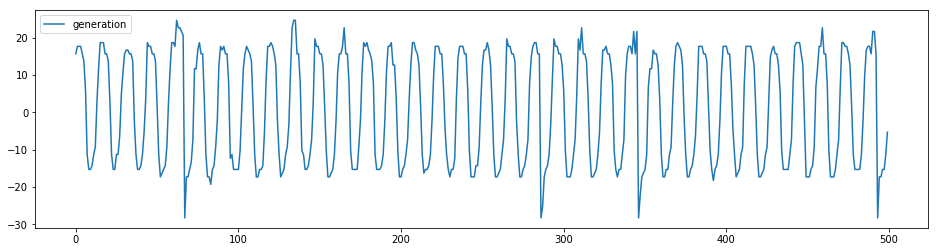

In [47]:
plt.figure(figsize=[16,4])
plt.plot(y_new[4000:4500])
plt.legend(['generation'])

In [54]:
Audio(y_gen, rate=4000)